# Object Detection in X-ray Images: Interview Task

Welcome to this technical interview task focusing on object detection in X-ray images. This notebook is designed to assess your skills in data analysis, model development, and result interpretation in the context of baggage X-ray imaging. The task should take around 3 hours.

## Background

You are interested in evaluating the quality of synthetic X-ray images for baggage screening. You wanted to use Fréchet Inception Distance(FID) to measure the difference between real data and synthetic data. However, you realise that the feature extractor used to calculate is inception-v3, a classifier model trained on solely natural images. You are worried that the domain difference between X-ray data and natural images will cause the results to be unreliable. Therefore, you have decided to **train an object detector on X-ray data and replace inception-v3 with the backbone of the object detector you trained, for Fréchet distance calculation**.  

## Task Description

You will be working with a dataset of X-ray images and tasked with developing an object detection model using Faster R-CNN with a ResNet-18 backbone and then using the backbone for calculating Fréchet distance. You are highly recommended to use PyTorch, but you can use other frameworks if you prefer. With Google Colab you can connect to a free T4, which would be sufficient for the model training here. The interview consists of 5 main questions with a total of 100 marks, each focusing on a different aspect of the machine learning pipeline:

1. Data Analysis: Explore and analyze the provided X-ray image dataset.
2. Data Preparation: Preprocess and prepare the data for model training.
3. Model Building and Fine-tuning: Implement and train the Faster R-CNN model.
4. Result Analysis: Evaluate the model's performance and interpret the results.
5. FID Calculation: Calculate the Fréchet distance to assess image quality with the backbone you have trained, similar to how Fréchet inception distance(FID) is calculated.

Please complete each section to the best of your ability. Feel free to add explanations, visualizations, or additional analyses as you see fit. Good luck!

*Note: If you are using Google Colab free T4 I suggest you start with a CPU to do data processing and preparation. Save the processed data on your Google Drive. Only connect to T4 after you reach Question 3 and mount the saved data to the T4 machine. This is because Google has a short time limit for the T4 runtime.*

## Question 1: Data Analysis (20 Marks, Suggested timing: 30 mins)

The dataset we are using is [DvXray](https://github.com/Mbwslib/DvXray?tab=readme-ov-file), please download the **positive** samples they provided on the github page and do the following tasks:

1. Keep images with indexes less than 500 and delete the rest. You should be left with 500 pairs of X-ray images and their corresponding json labels.
2. Analyze the distribution of object classes.
3. Visualize sample images with their annotations

In [1]:
import os
import shutil
import json
from collections import Counter
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import json
import random
import torch



In [2]:

# Define paths
original_data = 'DvXray_Positive_Samples'
filtered_data = 'Filtered_Positive_Samples'

# Create destination directory if it doesn't exist
os.makedirs(filtered_data, exist_ok=True)

# Filter files with indexes less than 500
for file_name in os.listdir(original_data):
    # Extract the index part from the filename for files with underscore or just the numeric index for JSON
    if '_' in file_name:
        index = int(file_name.split('_')[0].replace('P', ''))
    else:
        index = int(file_name.replace('P', '').replace('.json', ''))
    if index < 500:
        shutil.copy(os.path.join(original_data, file_name), filtered_data)
 
    


In [3]:
# count to check
ol_count = 0
sd_count = 0
json_count = 0

for file_name in os.listdir(filtered_data):
    if file_name.endswith('_OL.png'):
        ol_count += 1
    elif file_name.endswith('_SD.png'):
        sd_count += 1
    elif file_name.endswith('.json'):
        json_count += 1

# Print the counts
print(f"Number of _OL.png files: {ol_count}")
print(f"Number of _SD.png files: {sd_count}")
print(f"Number of .json files: {json_count}")


Number of _OL.png files: 500
Number of _SD.png files: 500
Number of .json files: 500


In [4]:
class_counter = Counter()
# Iterate through the files in the dataset directory
for file_name in os.listdir(filtered_data):
    if file_name.endswith('.json'):
        # Open and load the JSON file
        with open(os.path.join(filtered_data, file_name), 'r') as json_file:
            data = json.load(json_file)
            
            # Iterate through the objects in the JSON file
            for obj in data['objects']:
                # Increment the counter for the object label
                class_counter[obj['label']] += 1



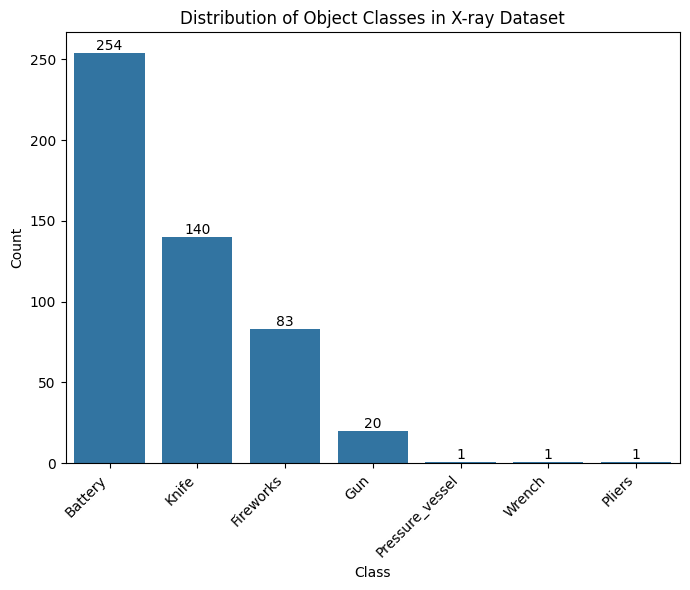

In [5]:

def plot_class_distribution_seaborn(class_counter):
    # Convert and sort data
    class_df = pd.DataFrame(class_counter.items(), columns=['Class', 'Count']).sort_values('Count', ascending=False)
    
    # Create the bar plot
    plt.figure(figsize=(7, 6))
    ax = sns.barplot(x='Class', y='Count', data=class_df)
    
    # Add value labels
    ax.bar_label(ax.containers[0], label_type='edge')
    
    # Set labels and title
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Object Classes in X-ray Dataset')
    plt.tight_layout()
    plt.show()


# Plot the example data using Seaborn
plot_class_distribution_seaborn(class_counter)


Rather imbalanced dataset

Visualising Sample Data with Annotations

Visualizing samples for class: Pressure_vessel


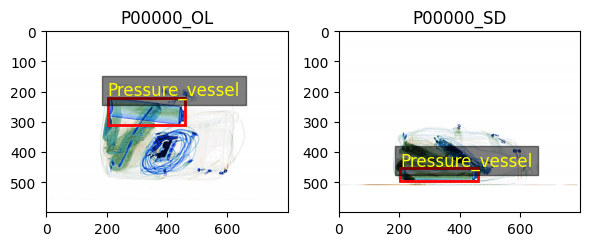

Visualizing samples for class: Wrench


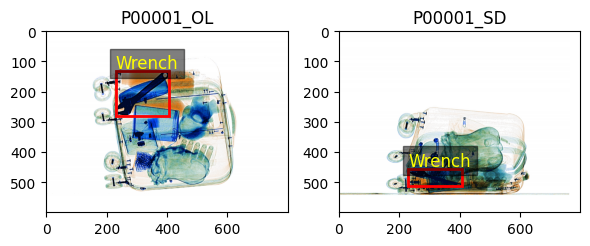

Visualizing samples for class: Knife


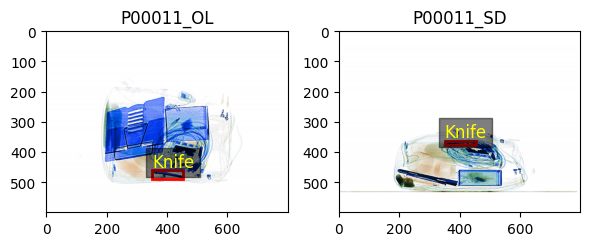

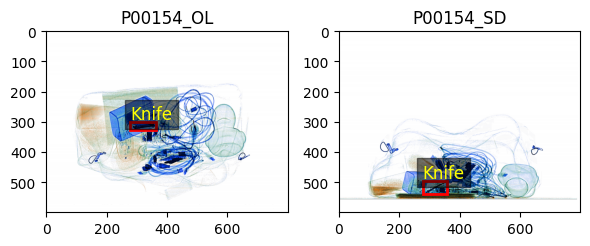

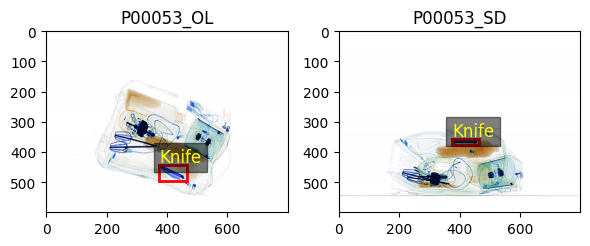

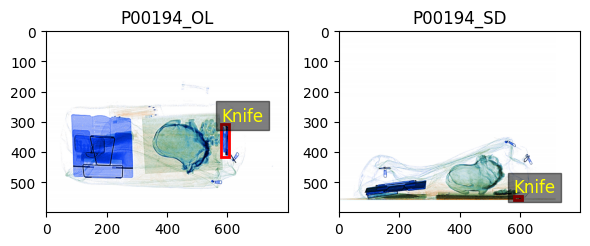

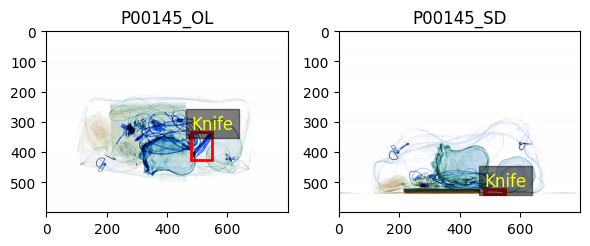

Visualizing samples for class: Pliers


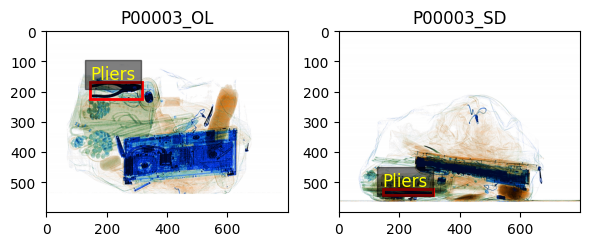

Visualizing samples for class: Battery


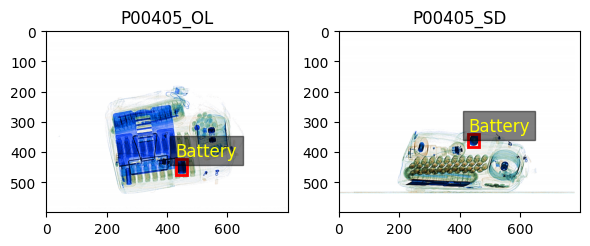

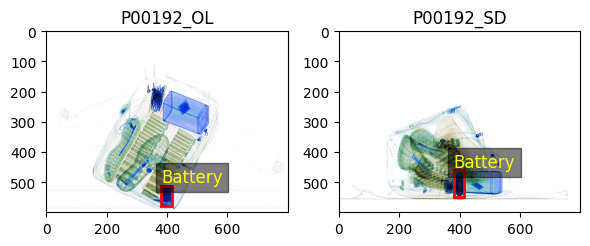

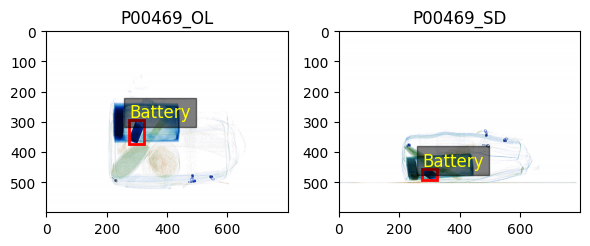

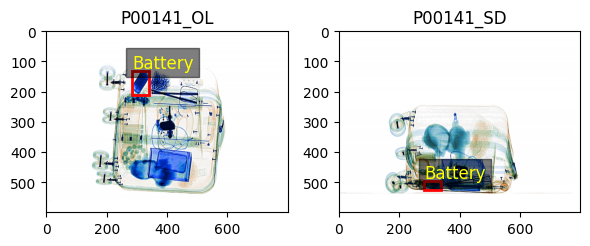

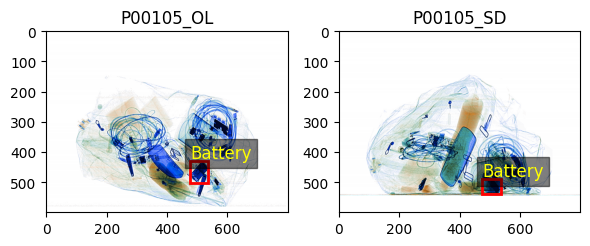

Visualizing samples for class: Fireworks


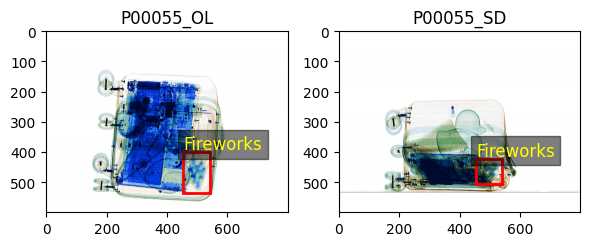

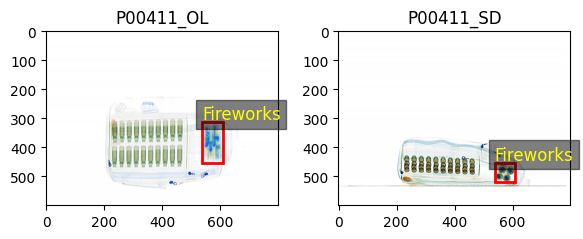

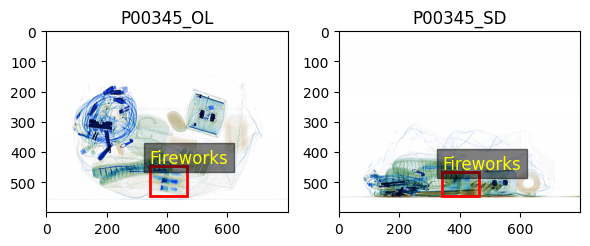

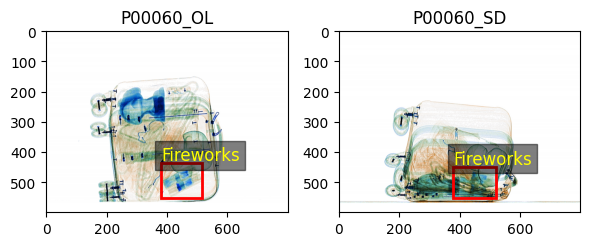

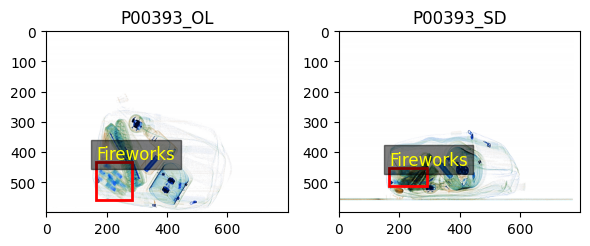

Visualizing samples for class: Gun


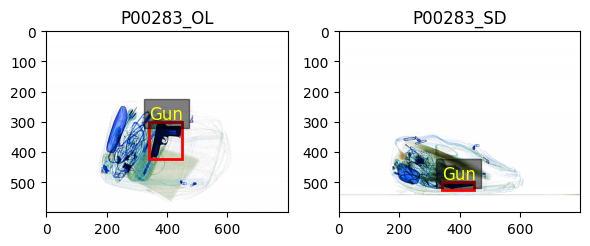

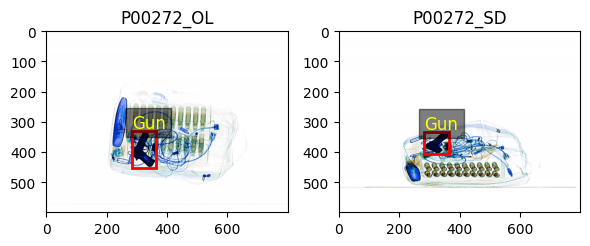

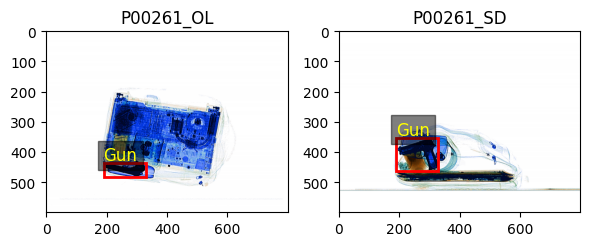

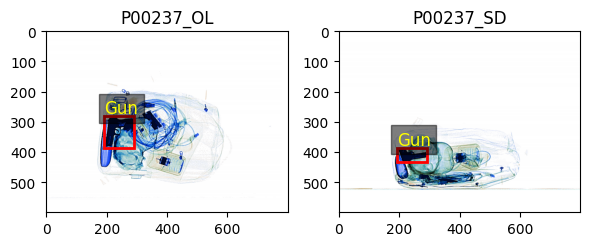

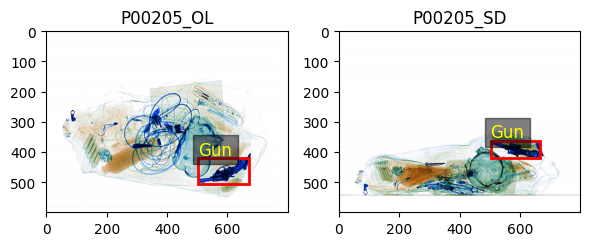

In [6]:
def get_class_samples(dataset_path, n_samples=5):
    """Collect samples for each class and randomly select n_samples per class."""
    class_samples = {}
    
    # Loop over the JSON files
    for file_name in os.listdir(dataset_path):
        if file_name.endswith('.json'):
            json_path = os.path.join(dataset_path, file_name)
            with open(json_path, 'r') as json_file:
                data = json.load(json_file)
                
                # Collect each object (class label) in the JSON
                for obj in data['objects']:
                    label = obj['label']
                    if label not in class_samples:
                        class_samples[label] = []
                    class_samples[label].append(file_name.replace('.json', ''))  # Store base filename without extension
    
    # Randomly select n_samples from each class
    selected_samples = {label: random.sample(files, min(n_samples, len(files))) for label, files in class_samples.items()}
    
    return selected_samples

def visualize_samples_with_annotations(selected_samples, dataset_path):
    for label, samples in selected_samples.items():
        print(f"Visualizing samples for class: {label}")
        
        for sample in samples:
            ol_image_path = os.path.join(dataset_path, sample + '_OL.png')
            sd_image_path = os.path.join(dataset_path, sample + '_SD.png')
            json_path = os.path.join(dataset_path, sample + '.json')
            
            try:
                # Load the images
                ol_image = Image.open(ol_image_path)
                sd_image = Image.open(sd_image_path)
            except FileNotFoundError as e:
                print(f"Error: {e}")
                continue  # Skip this sample if an image file is missing
            
            try:
                # Load the annotations
                with open(json_path, 'r') as json_file:
                    data = json.load(json_file)
            except json.JSONDecodeError as e:
                print(f"Error reading JSON file {json_path}: {e}")
                continue  # Skip this sample if the JSON file is corrupt
            
            # Set up the plot (1 row, 2 columns: one for OL, one for SD)
            fig, axes = plt.subplots(1, 2, figsize=(6, 4))
            
            try:
                # Plot the _OL image and annotations
                axes[0].imshow(ol_image)
                axes[0].set_title(f'{sample}_OL')
                plot_bounding_boxes(axes[0], data, 'ol_bb')
            except KeyError as e:
                print(f"Error with OL bounding box for {sample}: {e}")
                plt.close(fig)  # Close the figure to avoid showing a partial result
                continue  # Skip if there's an issue with OL bounding box
            
            try:
                # Plot the _SD image and annotations
                axes[1].imshow(sd_image)
                axes[1].set_title(f'{sample}_SD')
                plot_bounding_boxes(axes[1], data, 'sd_bb')
            except KeyError as e:
                print(f"Error with SD bounding box for {sample}: {e}")
                plt.close(fig)  # Close the figure to avoid showing a partial result
                continue  # Skip if there's an issue with SD bounding box
            
            plt.tight_layout()
            plt.show()

def plot_bounding_boxes(ax, data, bb_key):
    """Plot bounding boxes on the given axis."""
    for obj in data['objects']:
        try:
            # Convert the bounding box coordinates to integers or floats
            bbox = [float(coord) for coord in obj[bb_key]]
            
            # Create the rectangle using (x, y, width, height)
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                     linewidth=2, edgecolor='r', facecolor='none')
            
            # Add the rectangle to the plot
            ax.add_patch(rect)
            
            # Add the label above the bounding box
            ax.text(bbox[0], bbox[1] - 10, obj['label'], color='yellow', fontsize=12, bbox=dict(facecolor='black', alpha=0.5))
        except ValueError as e:
            print(f"Error converting bounding box: {e}")
            continue  # Skip this object if the bounding box is invalid



# Set the dataset path
dataset_path = 'Filtered_Positive_Samples'

# Step 1: Get 5 random samples per class
selected_samples = get_class_samples(dataset_path, n_samples=5)

# Step 2: Visualize the selected samples with annotations
visualize_samples_with_annotations(selected_samples, dataset_path)


## Question 2 Data Preparation (20 Marks, Suggested timing: 30 mins)

Your task is to train a faster-rcnn model with the given data. Prepare the data for model training by implementing the following code. Remember to split the data into train/val/test.

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import json
import os

class XrayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = self._load_samples()

    def _load_samples(self):
        """Helper function to load image paths and corresponding annotation paths."""
        samples = []
        for file_name in os.listdir(self.root_dir):
            if file_name.endswith('.json'):
                json_path = os.path.join(self.root_dir, file_name)
                base_name = file_name.replace('.json', '')
                ol_image_path = os.path.join(self.root_dir, base_name + '_OL.png')

                if os.path.exists(ol_image_path):
                    samples.append({
                        'ol_image': ol_image_path,
                        'json': json_path
                    })
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        # Load the OL image
        ol_image = Image.open(sample['ol_image']).convert("RGB")

        # Apply transformations if provided
        if self.transform:
            ol_image = self.transform(ol_image)

        # Load the annotations (JSON)
        with open(sample['json'], 'r') as f:
            annotations = json.load(f)

        # Extract bounding boxes (ol_bb) and labels from the objects
        ol_bboxes = []
        labels = []
        for obj in annotations['objects']:
            bbox_ol = obj['ol_bb']  # Extract 'ol_bb' for the bounding box
            label = obj['label']    # Extract the label

            ol_bboxes.append(bbox_ol)
            labels.append(self._get_label_index(label))  # Convert label to index

        # Convert bounding boxes and labels to tensors
        ol_bboxes = torch.tensor(ol_bboxes, dtype=torch.float32)  # Convert to FloatTensor [N, 4]
        labels = torch.tensor(labels, dtype=torch.int64)          # Convert to Int64Tensor [N]

        # Return the OL image and the target dictionary
        target = {
            'boxes': ol_bboxes,  # Bounding boxes [N, 4]
            'labels': labels     # Labels [N]
        }

        return ol_image, target
    def _get_label_index(self, label):
        """Convert the label string to an integer index."""
        class_mapping = {
            'Battery': 1,
            'Knife': 2,
            'Fireworks': 3,
            'Gun': 4,
            'Pressure_vessel': 5,
            'Wrench': 6,
            'Pliers': 7
        }

        return class_mapping.get(label, 0)  # Default to 0 if label is not found




In [5]:
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset and dataloaders
root_dir = 'Filtered_Positive_Samples'  # Directory where the images and CSV file are


# Create dataset and DataLoader
xray_dataset = XrayDataset(root_dir, transform=transform)

# Split dataset into train, validation, and test
train_idx, temp_idx = train_test_split(list(range(len(xray_dataset))), test_size=0.3, random_state=42)
test_idx, valid_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

# Create subsets
train_dataset = Subset(xray_dataset, train_idx)
valid_dataset = Subset(xray_dataset, valid_idx)
test_dataset = Subset(xray_dataset, test_idx)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)


In [6]:
for images, targets in train_loader:
    print(f"Images shape: {images.shape}")
    print(f"Targets: {targets}")
    break  # Just check one batch for demo

Images shape: torch.Size([4, 3, 224, 224])
Targets: {'boxes': tensor([[[345., 161., 472., 243.]],

        [[580., 271., 643., 322.]],

        [[201., 271., 251., 405.]],

        [[553., 365., 615., 435.]]]), 'labels': tensor([[3],
        [1],
        [3],
        [1]])}


## Question 3 Model Building and Training (20 Marks, Suggested timing: 60 mins)

With the dataloaders you implemented in the previous question, train a Faster RCNN detection model. The FasterRCNN model has been built for you. Good results from the trained model are **not expected** given the small dataset size and limited time. You can train the model for 10-20 epochs. Do record down what problems you have encountered and what you have tried during the training process.

In [7]:
import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Specify the number of classes (including the background class)
num_classes = 8  # Modify this based on your dataset

# Load a pre-trained ResNet-18 backbone
backbone = torchvision.models.resnet18(pretrained=True)

# Remove the last two layers (avgpool and fc)
backbone = torch.nn.Sequential(*list(backbone.children())[:-2])

# FasterRCNN needs to know the number of output channels in the backbone
backbone.out_channels = 512

# Define the anchor generator with different sizes and aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),  # Tuple of tuples for each feature map level
    aspect_ratios=((0.5, 1.0, 2.0),)   # Tuple for each feature map level
)

# Define the RoI pooler (Region of Interest Align)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],    # Feature map name
    output_size=7,          # RoI pooler output size (7x7)
    sampling_ratio=2        # Sampling ratio
)

# Create the Faster R-CNN model
model = FasterRCNN(
    backbone,
    num_classes=num_classes,                # Number of classes (including background)
    rpn_anchor_generator=anchor_generator,  # Anchor generator
    box_roi_pool=roi_pooler                 # RoI pooler
)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

print(model)


c:\Users\tiffa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\tiffa\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
       

In [8]:
import torch
from torch.optim import SGD

# Set the device (CPU or GPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Move the model to the correct device
model.to(device)

# Optimizer
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Number of epochs
num_epochs = 10


In [16]:
# Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [9]:
num_epochs = 10  # Set the number of epochs for training

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize epoch loss

    for images, targets in train_loader:
        print(targets)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        # Sum the losses
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagate the loss
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    # Step the scheduler after each epoch
    lr_scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# After training, you can save the model
torch.save(model.state_dict(), "fasterrcnn_xray_model.pth")


{'boxes': tensor([[[320., 395., 407., 472.]],

        [[205., 331., 257., 446.]],

        [[258., 217., 318., 260.]],

        [[473., 327., 513., 403.]]]), 'labels': tensor([[2],
        [3],
        [1],
        [1]])}


AttributeError: 'str' object has no attribute 'items'

In [17]:
targets

{'boxes': tensor([[[275., 350., 368., 409.]],
 
         [[485., 328., 593., 370.]],
 
         [[248., 384., 375., 492.]],
 
         [[249., 414., 307., 469.]]]),
 'labels': tensor([[2],
         [2],
         [3],
         [1]])}

## Question 4 (15 Marks, Suggested timing: 20 mins)

Analyze performance of your model on the test set. Calculate precision, recall and F1 score with an iou_threshold of 0.5 and detection confidence threshold of your choice.

## Question 5 (20 Marks, Suggested timing: 40 mins)

Write a function to calculate the Frechet distance between the dataset you are using and a given image with the Resnet-18 backbone you trained, similar to how FID is calculated. Calculate the distance for the three images specified below. Also answer the following questions.

1. Do you think it's a good idea to replace inception-v3, which is the default feature extractor used to calculate FID, with the Resnet-18 you have just trained?
2. What are the better alternatives than this Resnet-18 as feature extractor for X-ray synthetic data evaluation?
3. What are possible ways to test different metrics on how well they evaluate the difference between synthetic data and real data?

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from scipy import linalg

def extract_features(feature_extractor, dataloader):
    features = []
    with torch.no_grad():
        for batch in dataloader:
            if batch is None:
                continue
            images, _ = batch
            batch_features = []
            for image in images:
                # implement inference and feature dimension processing here.
            features.extend(batch_features)

    return np.concatenate(features)

def calculate_frechet_distance(real_features, generated_features):
    # make sure your inputs are numpy ndarrays with shape (n, d) and (m, d), where d is the size of the features extracted
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    frechet_distance = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return frechet_distance

def frechet_distance_with_image(image, transform, real_features, feature_extractor):
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    image = transform(image)

    with torch.no_grad():
        # Implement inference and feature dimension processing here.
        generated_features =

    return calculate_frechet_distance(real_features, generated_features)

# Implement Frechet distance calculation here for the three images, with the above functions.
image1_path = 'path/to/DvXray_Positive_Samples/P00001_OL.png'
image2_path = 'path/to/natural_image_sample.jpeg'
image3_path = 'path/to/xray_image_sample.jpeg'